# Solution for the Predict Prices task

### Task 1: Load the dataset and calculate the average price and estimated owners, and output to a file named output_1.csv

In [55]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from typing import Any, Tuple
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import csv 
import joblib
from dateutil import parser

# This function loads the dataset from the given path and returns the features and target variables, as well as the number of men, average duration of activity, 
# and number of senior users. 
# During evaluation set, the is_eval_dataset flag should be set to True
# During the second task, the is_handball_dataset should be set to True
# Load dataset and preprocess features using pandas
def load_data(dataset_path: str, is_eval_dataset=False, is_handball_dataset=False) -> Tuple[Any, Any, Any, int, float, int]:
    # Remove columns which you consider not relevant for calories prediction
    columns_to_drop = ["User_ID"]
    
    avg_duration = 0
    no_males = 0
    no_senior_users = 0

    # Load dataset from CSV file
    dataset = []
    with open(dataset_path, "r", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for row in reader:
            # First, remove columns that are not relevant for calories prediction
            for col in columns_to_drop:
                row.pop(col)

            # Convert numerical values to int or float
            for key, value in row.items():
                if value.replace('.', '', 1).isdigit():  # Check if it is a number
                    if '.' in value:
                        row[key] = float(value)  # Convert to float if decimal present
                    else:
                        row[key] = int(value)
                
            # Encode gender if available 
            if not(is_handball_dataset):
                
                if row["Gender"] == 'male':
                    no_males += 1
                    row["Gender"] = 0
                else:
                    row["Gender"] = 1
            dataset.append(row)

            avg_duration += row['Duration']

            if row['Age'] >= 75:
                no_senior_users += 1
            
    # Calculate average price and owners
    avg_duration = round(avg_duration / len(dataset), 2)

    
    target = "Calories"
    # Separate features (X) and target (y)
    X = []
    y = []    
    
    for row in dataset:
        features = {} 
        for key in row:
            if key != target:
                features[key] = row[key]
        X.append(features)
        y.append(row[target] if not is_eval_dataset else 0)

    # Return the output tuple        
    return pd.DataFrame(X), pd.DataFrame(y, columns=['Calories']), no_males, avg_duration, no_senior_users

# Load the full dataset
X, y, no_males, avg_duration, no_senior_users = load_data("dataset_train.csv")

# Output to a file named output_1.csv the number of samples, number of males, average duration
# and number of senior users
with open("output_0.csv", "w") as file:
    # Write the header with the required columns: number of samples, Average Price, Average Owners, and number of unique Genres
    file.write("Samples,No. Males,Average Duration,SeniorUsers\n")
    # Write the data
    file.write(f"{len(X)},{no_males},{avg_duration},{no_senior_users}\n")

### Dataset Analysis

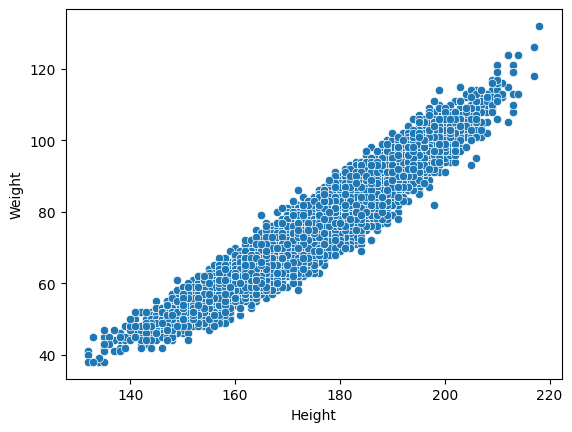

In [ ]:
# Scatter Plot heigh \ weight plot to check their 
sb.scatterplot(x='Height', y='Weight', data=X) 
plt.show()

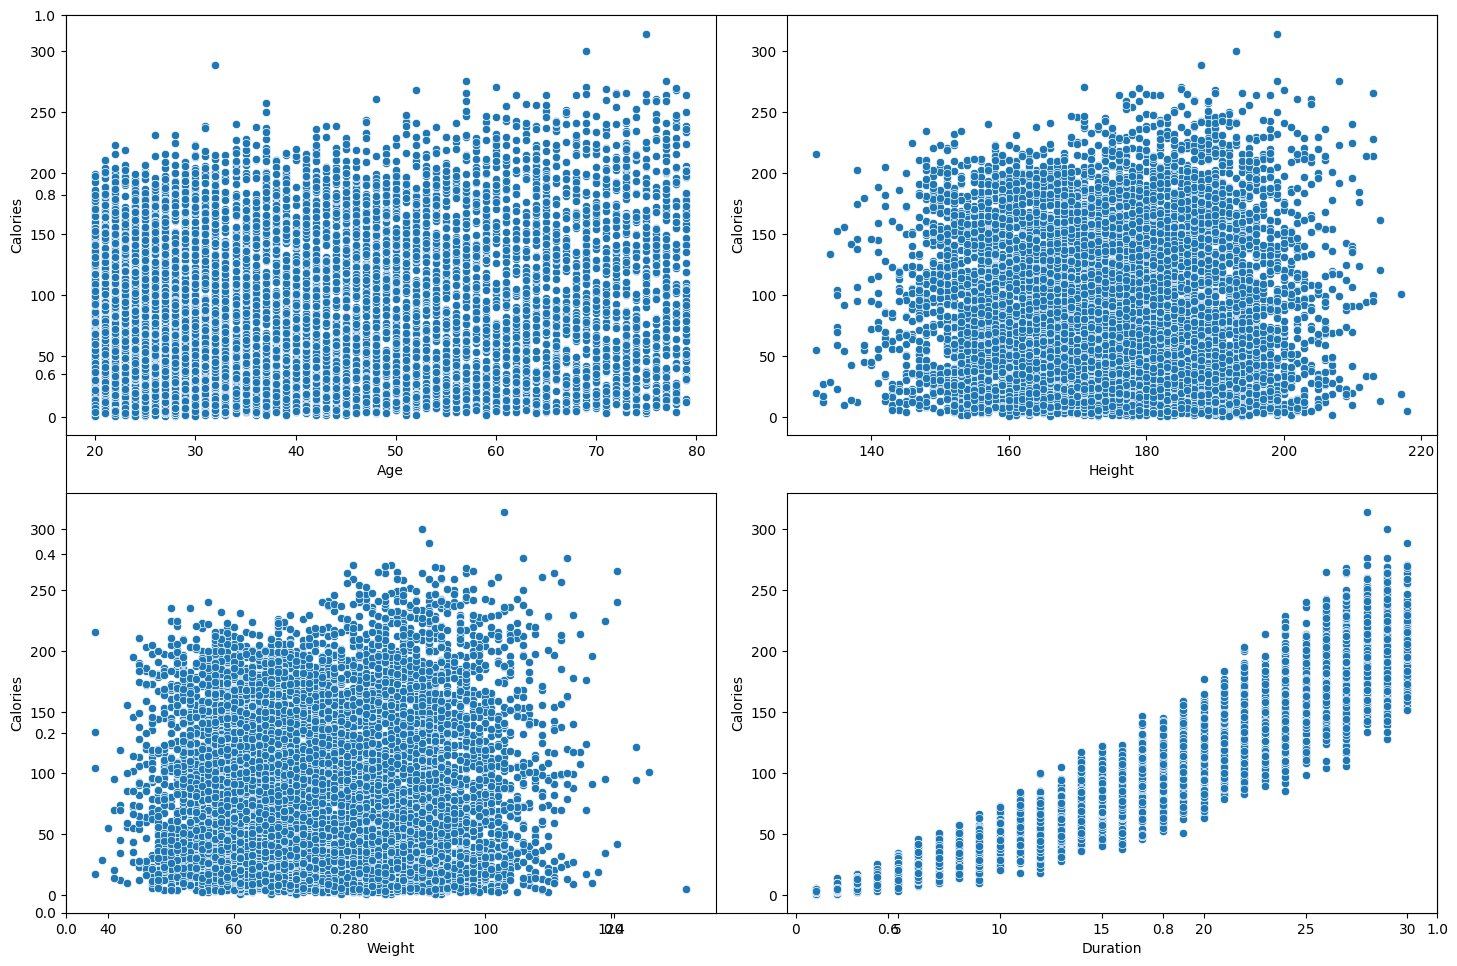

In [ ]:
# Scatter Plot different features together with calories

features = ['Age', 'Height', 'Weight', 'Duration']

plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sb.scatterplot(x=col, y='Calories', data=pd.concat([X, y], axis=1))
plt.tight_layout()
plt.show()

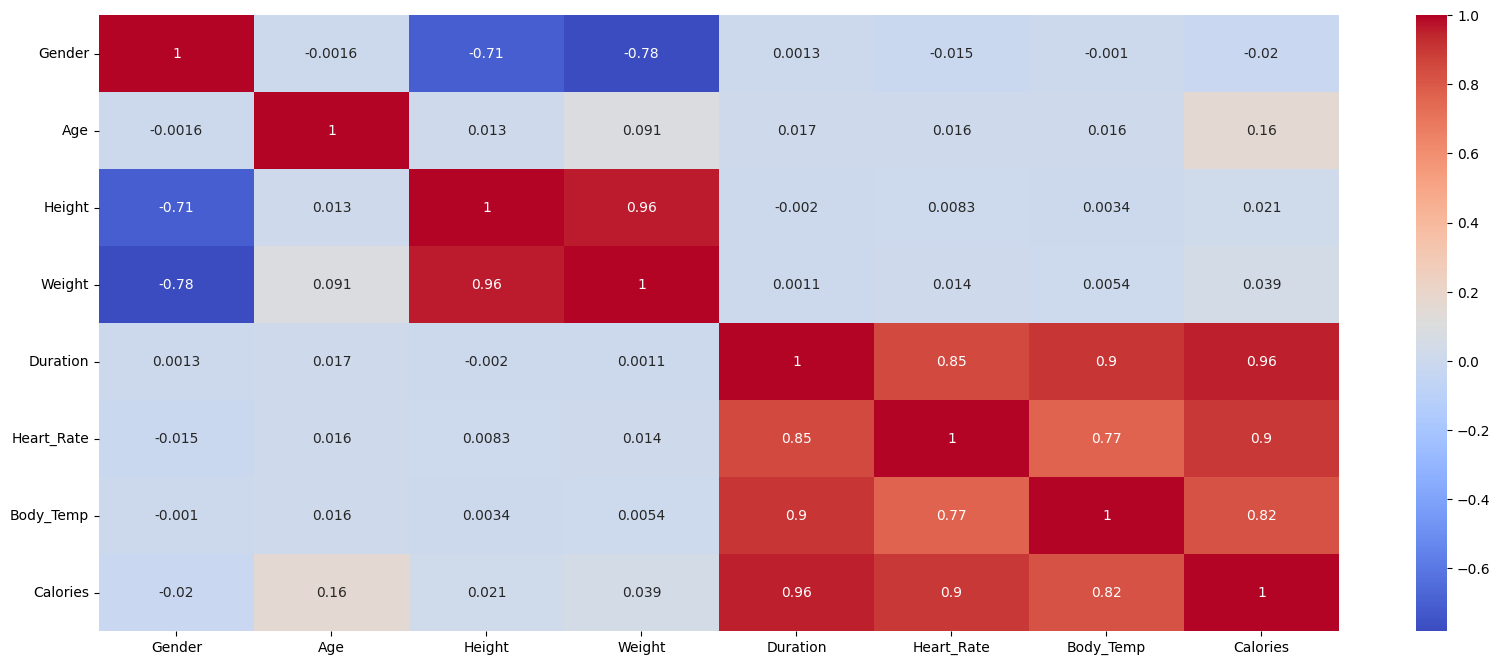

In [27]:
pd.concat([X, y], axis=1).corr()
plt.figure(figsize=(20, 8))
sb.heatmap(pd.concat([X, y], axis=1).corr(), annot=True, cmap="coolwarm")
plt.show()

### Train your model - Play as you like from here to get the best AI model ####

In [ ]:
X = X
y = y # .ravel()

def normalize_data(df: pd.DataFrame) -> pd.DataFrame:
    df_normalized = df.copy()
    for column in df.select_dtypes(include=['number']).columns:
        df_normalized[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    return df_normalized

# Returns the model trained on the given features and target variables
def train_model(X: pd.DataFrame, y: pd.DataFrame) -> Any:

    # More pre-processing first
    X = normalize_data(X)
    X = X.drop(columns=['Height', 'Body_Temp', 'Heart_Rate'], errors='ignore')

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Define the model
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions and evaluate the model on your test set
    y_pred = model.predict(X_test)

    # Calculate the mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    
    return model

# Call model training and saving. This will save the model to a file named trained_model.pkl
trained_model = train_model(X, y)
# joblib.dump(trained_model, "trained_model.pkl")

Index(['Gender', 'Age', 'Weight', 'Duration'], dtype='object')


c:\Users\Mano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Mean Absolute Error: 8.588209277606756


### Task 2: Load the model and the evaluation dataset, and make predictions, and output to a file named output_1.csv

In [ ]:
def predict_calories(trained_model: Any, dataset_path: str, output_file: str, gender_input = True) -> pd.DataFrame:
    # Load the model
    # model = joblib.load(trained_model)
    
    # Load the evaluation dataset
    X_eval, _, _, _, _ = load_data(dataset_path, is_eval_dataset=True, is_handball_dataset=not(gender_input))

    X_eval = normalize_data(X_eval)
    X_eval = X_eval.drop(columns=['Height', 'Body_Temp', 'Heart_Rate'], errors='ignore')


    if not(gender_input):
        X_eval['Gender'] = 0
        # Move Gender column to beginning to match training set-up 
        X_eval = X_eval[['Gender'] + [col for col in X_eval.columns if col != 'Gender']]
    
    # Make predictions
    y_pred = trained_model.predict(X_eval)
    
    # Save the predictions to a file named output_2.csv with a single column of predictions
    # no pandas 
    with open(output_file, "w") as file:
        # Write the header
        file.write("Calories\n")
        # Write the predictions
        for pred in y_pred:
            file.write(str(pred) + "\n")
    
    
# trained_model = joblib.load("Output_CandidatX/trained_model.pkl")
predict_calories(trained_model, "task1_dataset_eval.csv", "output_1.csv")

Index(['Gender', 'Age', 'Weight', 'Duration'], dtype='object')


### Task 3 - Create model for the handball man team

In [54]:
predict_calories(trained_model, "task2_dataset_eval.csv", "output_2.csv", gender_input=False)

Index(['Age', 'Weight', 'Duration'], dtype='object')
